# 查看根目录下需要运行的文件夹

In [21]:
from pathlib import Path

version = "v1"
run_type = "pose_and_det"  # "pose_and_det" or "cls"

path = Path("/workspace/models/SAHI/run_v8")
chosen_dirs = [d / "raw_data" for d in path.iterdir() if d.is_dir()]
print("子文件夹路径列表：", chosen_dirs)

子文件夹路径列表： [PosixPath('/workspace/models/SAHI/run_v8/ms1_0726-0809_11/raw_data')]


# objects去重，结果可视化
### 输入输出
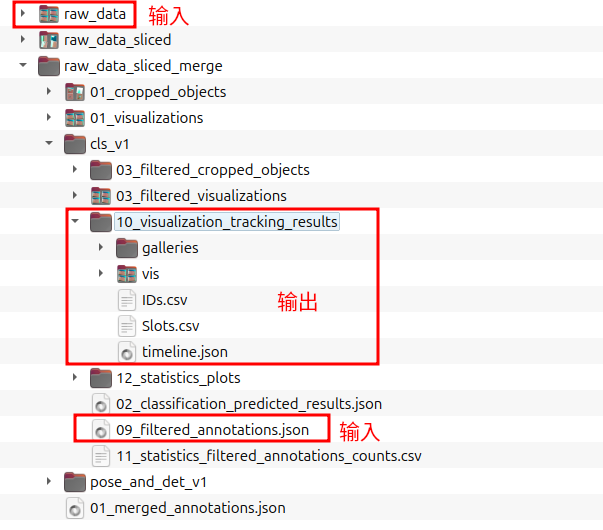


### 效果
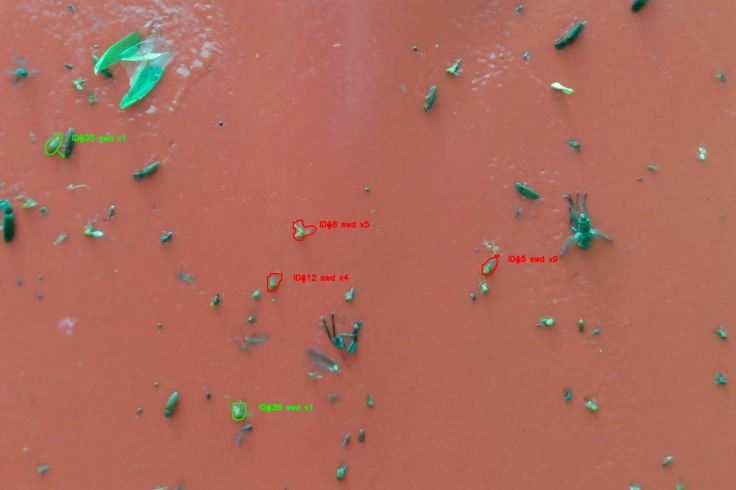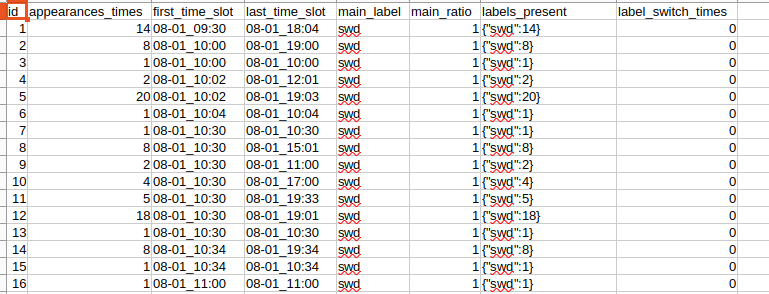

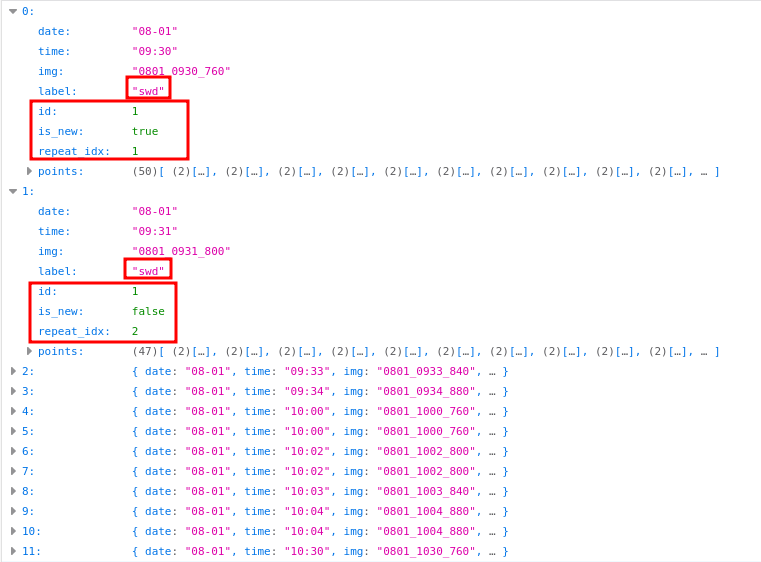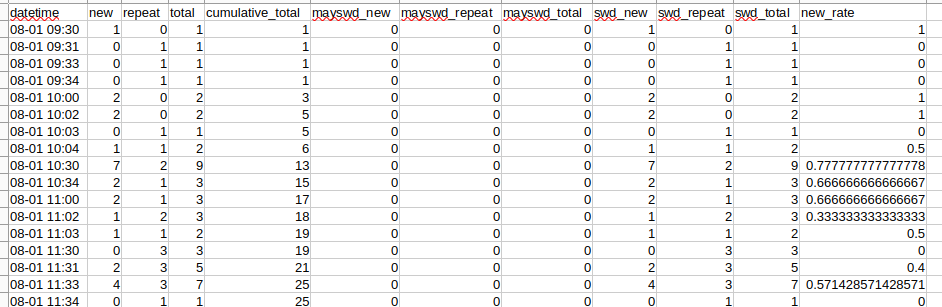

In [15]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

"""
时间序列目标跟踪与可视化系统（仅多边形 + poly_iou）
- 输入：类似 09_filtered_annotations.json 的 dict[name] -> List[annotation]，annotation 必须包含:
        label, points(多边形), original_name(可选), uuid(可选), score(可选)
- 原图目录：raw_data/ 下的 *.jpg，文件名以键名为前缀（如 0801_1034_880*.jpg）
- 命名解析：MMDD_HHMM（示例：0801_1034_880）

功能：
1) assign_persistent_ids：跨时刻匹配分配稳定 ID（poly IoU）
2) draw_overlays：原图叠加可视化（新=绿，重复=红、幽灵轨迹、右上角 NOW/SUM 徽标）
3) build_track_galleries：按 ID 裁剪时间序列小图
4) export_stats_B：导出统计（Slots.csv & IDs.csv）
5) 保存完整时间线 JSON（timeline.json）

依赖：shapely, numpy, opencv-python, orjson
"""

import os
import re
from pathlib import Path
from typing import Any, Dict, List, Tuple, Optional, Iterable
from collections import defaultdict, Counter

import numpy as np
import cv2
import orjson
import json as pyjson

# ============== 强制依赖 shapely（仅多边形 + poly_iou） ==============
try:
    from shapely.geometry import Polygon
except Exception as e:
    raise ImportError(
        "本脚本仅支持多边形 + poly_iou，请先安装 shapely：\n"
        "  pip install shapely\n"
    ) from e


# ============== 时间解析：文件名 MMDD_HHMM[...] ==============
_FN_RE = re.compile(r"(?P<mm>\d{2})(?P<dd>\d{2})_(?P<hh>\d{2})(?P<mi>\d{2})")

def parse_mmdd_hhmm(name: str) -> Optional[Tuple[str, str]]:
    """
    返回 (date_str 'MM-DD', time_str 'HH:MM')，失败返回 None
    """
    m = _FN_RE.search(name)
    if not m:
        return None
    mm, dd, hh, mi = m.group("mm", "dd", "hh", "mi")
    return f"{mm}-{dd}", f"{hh}:{mi}"

def slot_sort_key(date_str: str, time_str: str) -> Tuple[int,int,int,int]:
    return (int(date_str[:2]), int(date_str[3:]), int(time_str[:2]), int(time_str[3:]))


# ============== IO ==============
def json_load(path: Path) -> Dict[str, Any]:
    with open(path, "rb") as f:
        return orjson.loads(f.read())

def json_dump(obj: Any, path: Path):
    path.parent.mkdir(parents=True, exist_ok=True)
    with open(path, "wb") as f:
        f.write(orjson.dumps(obj, option=orjson.OPT_INDENT_2))


# ============== 原图索引 ==============
def build_image_index(image_dir: Path) -> Dict[str, str]:
    """
    返回 {stem -> path}，若找不到精确 stem，后续会尝试前缀匹配
    """
    idx = {}
    for p in image_dir.glob("*.jpg"):
        idx[p.stem] = str(p)
    return idx


# ============== 多边形 IoU（仅 shapely） ==============
def poly_iou(poly_a: List[List[float]], poly_b: List[List[float]]) -> float:
    try:
        A = Polygon(poly_a)
        B = Polygon(poly_b)
        if not (A.is_valid and B.is_valid):
            return 0.0
        inter = A.intersection(B).area
        if inter <= 0:
            return 0.0
        u = A.area + B.area - inter
        return float(inter / u) if u > 0 else 0.0
    except Exception:
        return 0.0


# ============== 标签标准化 / 过滤（可选） ==============
def make_label_normalizer(label_map: Optional[Dict[str, str]] = None,
                          whitelist: Optional[Iterable[str]] = None):
    """
    返回 normalize(label) -> 标准化后的 label
    - label_map: 别名到统一名，如 {'SWD':'swd','MAYSWD':'mayswd','may_swd':'mayswd'}
    - whitelist: 只保留白名单中的标签；不在白名单则返回 'other'（或返回 '' 表示忽略）
    """
    label_map = {k.lower(): v for k, v in (label_map or {}).items()}
    wl = set(x.lower() for x in whitelist) if whitelist else None

    def normalize(label: str) -> str:
        if label is None:
            return ""
        s = str(label).strip()
        if not s:
            return ""
        s_lo = s.lower()
        s_std = label_map.get(s_lo, s_lo)
        if wl is not None and s_std not in wl:
            return "other"  # 如需忽略可改为返回 ""
        return s_std
    return normalize


# ============== 数据读取：09_filtered_annotations.json（支持 normalize_label） ==============
def load_annotations_json(json_path: Path, 
                            normalize_label=None) -> Dict[str, List[Dict[str, Any]]]:
    """
    期望结构：{ img_key: [ {label, points, ...}, ... ], ... }
    仅使用 points 多边形；若缺失则跳过该条 annotation
    """
    if normalize_label is None:
        normalize_label = lambda x: ("" if x is None else str(x))

    data = json_load(json_path)
    cleaned: Dict[str, List[Dict[str, Any]]] = {}
    for img_key, anns in data.items():
        keep = []
        for a in anns or []:
            pts = a.get("points")
            if isinstance(pts, list) and len(pts) >= 3:
                lab = normalize_label(a.get("label"))
                keep.append({
                    "label": lab,
                    "points": [[float(x), float(y)] for x, y in pts],
                    "uuid": a.get("uuid"),
                    "original_name": a.get("original_name", img_key),
                    "score": a.get("score"),
                })
        if keep:
            cleaned[img_key] = keep
    return cleaned


# ============== 稳定 ID 分配（仅 poly_iou） ==============
def assign_persistent_ids(
    cleaned_annotations: Dict[str, List[Dict[str, Any]]],
    iou_threshold: float = 0.5,
    class_agnostic: bool = False
) -> Tuple[List[Dict[str, Any]], Dict[int, List[Dict[str, Any]]]]:
    """
    返回：
      - timeline: List[ {date,time,img,label,id,is_new,repeat_idx,points} ]
      - id_tracks: Dict[id] -> List[occurrence(dict)]
    匹配策略：
      - 同时刻内部去重：相同 label（或 class_agnostic=True）之间 IoU >= 阈值视为重复，仅保留一个
      - 跨时刻匹配：与“已见库”中 IoU 最高且 >= 阈值者匹配，否则分配新 ID
    """
    by_slot: Dict[Tuple[str, str], List[Tuple[str, Dict[str, Any]]]] = defaultdict(list)
    for img_key, anns in cleaned_annotations.items():
        ts = parse_mmdd_hhmm(img_key)
        if not ts:
            continue
        d, t = ts
        for a in anns:
            by_slot[(d, t)].append((img_key, a))

    slots = sorted(by_slot.keys(), key=lambda k: slot_sort_key(k[0], k[1]))

    next_id = 1
    pool_by_label: Dict[str, List[Dict[str, Any]]] = defaultdict(list)
    pool_all: List[Dict[str, Any]] = []
    id_tracks: Dict[int, List[Dict[str, Any]]] = defaultdict(list)
    timeline: List[Dict[str, Any]] = []

    for d, t in slots:
        obs = by_slot[(d, t)]

        # 1) 同时刻内部去重
        unique_obs: List[Tuple[str, Dict[str, Any]]] = []
        for img_key, det in obs:
            label, pts = det.get("label", ""), det.get("points")
            if not pts:
                continue
            dup = False
            for _, u in unique_obs:
                if (not class_agnostic) and (u.get("label", "") != label):
                    continue
                s = poly_iou(pts, u["points"])
                if s >= iou_threshold:
                    dup = True
                    break
            if not dup:
                unique_obs.append((img_key, det))

        # 2) 跨时刻匹配
        for img_key, det in unique_obs:
            label, pts = det.get("label", ""), det.get("points")
            candidates = pool_all if class_agnostic else pool_by_label[label]
            best = None
            best_s = -1.0
            for c in candidates:
                s = poly_iou(pts, c["points"])
                if s >= iou_threshold and s > best_s:
                    best = c
                    best_s = s

            if best is None:
                cur_id = next_id
                next_id += 1
                entry = {"id": cur_id, "points": pts, "last_dt": (d, t)}
                if class_agnostic:
                    pool_all.append(entry)
                else:
                    pool_by_label[label].append(entry)
                repeat_idx = 1
                is_new = True
            else:
                cur_id = best["id"]
                best["points"] = pts or best["points"]
                best["last_dt"] = (d, t)
                repeat_idx = len(id_tracks[cur_id]) + 1
                is_new = False

            occ = {
                "date": d, "time": t, "img": img_key,
                "label": label, "id": cur_id, "is_new": is_new,
                "repeat_idx": repeat_idx, "points": pts
            }
            id_tracks[cur_id].append(occ)
            timeline.append(occ)

    return timeline, id_tracks


# ============== 可视化：右上角计数徽标 ==============
def draw_top_right_counter(canvas: np.ndarray, now: int, cum: int):
    H, W = canvas.shape[:2]
    margin = max(8, W // 200)
    pad = max(8, W // 300)
    font = cv2.FONT_HERSHEY_SIMPLEX
    font_scale = max(0.8, min(2.2, W / 800.0))
    thickness = max(2, int(round(font_scale + 1)))

    line1 = f"NOW: {now}"
    line2 = f"SUM: {cum}"

    (w1, h1), _ = cv2.getTextSize(line1, font, font_scale, thickness)
    (w2, h2), _ = cv2.getTextSize(line2, font, font_scale, thickness)
    box_w = max(w1, w2) + 2 * pad
    line_gap = max(6, int(0.25 * h1))
    box_h = h1 + h2 + line_gap + 2 * pad

    x2 = W - margin
    y1 = margin
    x1 = x2 - box_w
    y2 = y1 + box_h

    overlay = canvas.copy()
    cv2.rectangle(overlay, (x1, y1), (x2, y2), (0, 0, 0), thickness=-1)
    cv2.addWeighted(overlay, 0.55, canvas, 0.45, 0, dst=canvas)

    tx = x1 + pad
    ty1 = y1 + pad + h1
    ty2 = ty1 + line_gap + h2
    cv2.putText(canvas, line1, (tx, ty1), font, font_scale, (255, 255, 255), thickness, cv2.LINE_AA)
    cv2.putText(canvas, line2, (tx, ty2), font, font_scale, (255, 255, 255), thickness, cv2.LINE_AA)


# ============== 可视化：叠加绘制（新=绿，重复=红，幽灵轨迹） ==============
def draw_overlays(
    timeline: List[Dict[str, Any]],
    image_dir: Path,
    out_dir: Path,
    ghost_trail_steps: int = 0,
    ghost_alpha: float = 0.25
):
    os.makedirs(out_dir, exist_ok=True)
    index = build_image_index(image_dir)

    # 分图收集
    by_img = defaultdict(list)
    for r in timeline:
        by_img[r["img"]].append(r)

    # 按时间排序的全局时间线，用于回溯轨迹
    def dt_key(r): return slot_sort_key(r["date"], r["time"])
    timeline_sorted = sorted(timeline, key=dt_key)
    hist_by_id = defaultdict(list)
    for r in timeline_sorted:
        hist_by_id[r["id"]].append(r)

    # 为徽标准备 per-slot now/cum，并映射到图
    per_slot_counts = Counter()
    cum_total = 0
    slot_order = sorted({(r["date"], r["time"]) for r in timeline}, key=lambda x: slot_sort_key(*x))
    slot_to_cum = {}
    for d, t in slot_order:
        now = sum(1 for r in timeline if r["date"] == d and r["time"] == t and r["is_new"])
        cum_total += now
        per_slot_counts[(d, t)] = now
        slot_to_cum[(d, t)] = cum_total

    for img_key, rows in by_img.items():
        # 找原图
        img_path = index.get(img_key)
        if img_path is None:
            for p in Path(image_dir).glob(f"{img_key}*.jpg"):
                img_path = str(p); break
        if not img_path or not os.path.exists(img_path):
            continue

        canvas = cv2.imread(img_path)
        if canvas is None:
            continue

        # 幽灵轨迹
        if ghost_trail_steps > 0:
            ghost = canvas.copy()
            for r in rows:
                hist = hist_by_id[r["id"]]
                idx = None
                for i, k in enumerate(hist):
                    if k["img"] == img_key:
                        idx = i; break
                if idx is None: 
                    continue
                start = max(0, idx - ghost_trail_steps)
                for j in range(start, idx):
                    pj = hist[j]
                    pts = np.asarray(pj["points"], dtype=np.int32).reshape(-1,1,2)
                    cv2.polylines(ghost, [pts], True, (200,200,200), 1, cv2.LINE_AA)
            canvas = cv2.addWeighted(ghost, ghost_alpha, canvas, 1-ghost_alpha, 0)

        # 当前多边形
        for r in rows:
            pts = r["points"]
            if not pts:
                continue
            pts_i = np.asarray(pts, dtype=np.int32).reshape(-1,1,2)
            color = (0,255,0) if r["is_new"] else (0,0,255)  # 新=绿，重复=红
            cv2.polylines(canvas, [pts_i], True, color, 2, cv2.LINE_AA)

            # 标注文字（ID/label/出现次数）
            if pts_i.size > 0:
                xs = [p[0] for p in pts]; ys = [p[1] for p in pts]
                x1, y1 = int(min(xs)) + 8, int(min(ys)) + 18
                txt = f"ID#{r['id']} {r.get('label','')} x{r['repeat_idx']}"
                cv2.putText(canvas, txt, (x1 + 64, y1), cv2.FONT_HERSHEY_SIMPLEX, 0.7, color, 2, cv2.LINE_AA)

        # 右上角徽标
        dd, tt = parse_mmdd_hhmm(img_key) or (None, None)
        if dd and tt:
            now = per_slot_counts[(dd, tt)]
            cum = slot_to_cum[(dd, tt)]
            draw_top_right_counter(canvas, now=now, cum=cum)

        out_path = os.path.join(out_dir, f"{img_key}_track_vis.jpg")
        cv2.imwrite(out_path, canvas, [int(cv2.IMWRITE_JPEG_QUALITY), 90])


# ============== 轨迹相册（按 ID 裁剪序列） ==============
def _crop_square(img: np.ndarray, pts: List[List[float]], margin: int = 8) -> Optional[np.ndarray]:
    H, W = img.shape[:2]
    xs = [p[0] for p in pts]; ys = [p[1] for p in pts]
    x1, y1, x2, y2 = int(min(xs)), int(min(ys)), int(max(xs)), int(max(ys))
    side = max(x2 - x1, y2 - y1)
    cx, cy = (x1 + x2) // 2, (y1 + y2) // 2
    l = max(0, cx - side//2 - margin)
    t = max(0, cy - side//2 - margin)
    r = min(W, cx + side//2 + margin)
    b = min(H, cy + side//2 + margin)
    if r - l <= 1 or b - t <= 1:
        return None
    return img[t:b, l:r].copy()

def build_track_galleries(
    id_tracks: Dict[int, List[Dict[str, Any]]],
    image_dir: Path,
    out_dir: Path,
    margin: int = 8,
    workers: Optional[int] = None,
    jpeg_quality: int = 90
):
    os.makedirs(out_dir, exist_ok=True)
    index = build_image_index(image_dir)
    # 每个 id 一个文件夹
    save_dirs = {}
    for tid in id_tracks.keys():
        d = os.path.join(out_dir, f"id_{tid:04d}")
        os.makedirs(d, exist_ok=True)
        save_dirs[tid] = d

    tasks_by_img: Dict[str, List[Tuple[List[List[float]], str]]] = defaultdict(list)
    _fallback: Dict[str, Optional[str]] = {}

    for tid, occs in id_tracks.items():
        occs_sorted = sorted(occs, key=lambda r: slot_sort_key(r["date"], r["time"]))
        for k, r in enumerate(occs_sorted, start=1):
            pts = r.get("points")
            if not pts:
                continue
            img_key = r["img"]
            img_path = index.get(img_key)
            if img_path is None:
                if img_key not in _fallback:
                    hit = None
                    for p in Path(image_dir).glob(f"{img_key}*.jpg"):
                        hit = str(p); break
                    _fallback[img_key] = hit
                img_path = _fallback[img_key]
            if not img_path or not os.path.exists(img_path):
                continue
            fn = f"{k:02d}_{r['date']}_{r['time']}_{img_key}.jpg"
            save_path = os.path.join(save_dirs[tid], fn)
            tasks_by_img[img_path].append((pts, save_path))

    if not tasks_by_img:
        return

    params = [int(cv2.IMWRITE_JPEG_QUALITY), int(jpeg_quality)]

    def _process(img_path: str, todo: List[Tuple[List[List[float]], str]]):
        img = cv2.imread(img_path)
        if img is None:
            return 0
        ok = 0
        for pts, save_path in todo:
            crop = _crop_square(img, pts, margin=margin)
            if crop is None:
                continue
            cv2.imwrite(save_path, crop, params)
            ok += 1
        return ok

    if workers is None:
        workers = min(32, (os.cpu_count() or 4) + 4)

    import concurrent.futures
    with concurrent.futures.ThreadPoolExecutor(max_workers=workers) as ex:
        futs = [ex.submit(_process, p, todo) for p, todo in tasks_by_img.items()]
        for _ in concurrent.futures.as_completed(futs):
            pass


# ============== 统一统计（按你的字段要求改名/精简） ==============
def export_stats_B(
    timeline: list,
    slots_csv_path: str,
    ids_csv_path: str,
    final_label_by_id: dict | None = None,      # 仍保留接口，但不再输出到 IDs.csv
    final_conf_by_id: dict | None = None
):
    """
    输出：
    - Slots.csv：datetime,new,repeat,total,cumulative_total,<label>_new,<label>_repeat,<label>_total,...,new_rate
      （移除 date,time）
    - IDs.csv：id,appearances_times,first_time_slot,last_time_slot,main_label,main_ratio,
               labels_present(对象字符串),label_switch_times
      （移除 span_slots/final_label/final_label_confidence/num_labels/purity/各 <label>_count 动态列）
    """
    import csv
    from collections import defaultdict, Counter

    # 空输入时：写表头
    if not timeline:
        with open(slots_csv_path, "w", newline="", encoding="utf-8") as f:
            csv.writer(f).writerow(["datetime","new","repeat","total","cumulative_total","new_rate"])
        with open(ids_csv_path, "w", newline="", encoding="utf-8") as f:
            csv.writer(f).writerow([
                "id","appearances_times","first_time_slot","last_time_slot",
                "main_label","main_ratio","labels_present","label_switch_times"
            ])
        return

    def slot_key(d, t):  # d='MM-DD', t='HH:MM'
        return (int(d[:2]), int(d[3:]), int(t[:2]), int(t[3:]))

    # —— 标签全集（按字母序稳定） —— #
    labels = sorted({str(r.get("label","")) for r in timeline if str(r.get("label","")) != ""})

    # =========================
    # 1) SLOTS（每时间槽聚合）
    # =========================
    grp = defaultdict(list)  # (date,time) -> [rows...]
    for r in timeline:
        grp[(r["date"], r["time"])] .append(r)

    ordered_slots = sorted(grp.keys(), key=lambda dt: slot_key(dt[0], dt[1]))

    cum_total = 0
    slot_rows = []
    for d, t in ordered_slots:
        sub = grp[(d, t)]
        new_cnt    = sum(1 for x in sub if x.get("is_new", False) is True)
        repeat_cnt = sum(1 for x in sub if x.get("is_new", False) is False)
        total_cnt  = len(sub)
        cum_total += new_cnt

        row = {
            "datetime": f"{d} {t}",
            "new": new_cnt,
            "repeat": repeat_cnt,
            "total": total_cnt,
            "cumulative_total": cum_total,
            "new_rate": (new_cnt / total_cnt) if total_cnt else 0.0,
        }

        for lab in labels:
            lab_sub = [x for x in sub if str(x.get("label","")) == lab]
            lab_new = sum(1 for x in lab_sub if x.get("is_new", False) is True)
            lab_rep = sum(1 for x in lab_sub if x.get("is_new", False) is False)
            row[f"{lab}_new"]    = lab_new
            row[f"{lab}_repeat"] = lab_rep
            row[f"{lab}_total"]  = lab_new + lab_rep

        slot_rows.append(row)

    slot_header = ["datetime","new","repeat","total","cumulative_total"]
    for lab in labels:
        slot_header += [f"{lab}_new", f"{lab}_repeat", f"{lab}_total"]
    slot_header += ["new_rate"]

    with open(slots_csv_path, "w", newline="", encoding="utf-8") as f:
        w = csv.DictWriter(f, fieldnames=slot_header)
        w.writeheader()
        for r in slot_rows:
            w.writerow(r)

    # =========================
    # 2) IDs（每轨迹聚合）
    # =========================
    by_id = defaultdict(list)
    for r in timeline:
        by_id[int(r["id"])] .append(r)

    id_rows = []
    for tid, occs in by_id.items():
        occs_sorted = sorted(occs, key=lambda r: slot_key(r["date"], r["time"]))
        appearances = len(occs_sorted)
        first_slot  = f"{occs_sorted[0]['date']}_{occs_sorted[0]['time']}"
        last_slot   = f"{occs_sorted[-1]['date']}_{occs_sorted[-1]['time']}"

        # —— 计数每个 label —— #
        cnt = Counter(str(o.get("label","")) for o in occs_sorted if str(o.get("label","")) != "")
        main_lab, main_cnt = ("", 0)
        if cnt:
            main_lab, main_cnt = max(cnt.items(), key=lambda kv: kv[1])
        main_ratio = (main_cnt / appearances) if appearances else 0.0

        # —— 类别切换次数（按时间序） —— #
        label_seq = [str(o.get("label","")) for o in occs_sorted]
        label_seq = [x for x in label_seq if x != ""]
        switch_times = sum(1 for i in range(1, len(label_seq)) if label_seq[i] != label_seq[i-1])

        # —— labels_present 以对象字符串输出 —— #
        labels_present_obj = {lab: cnt[lab] for lab in sorted(cnt.keys())}
        labels_present_str = pyjson.dumps(labels_present_obj, ensure_ascii=False, separators=(',',':'))

        row = {
            "id": tid,
            "appearances_times": appearances,
            "first_time_slot": first_slot,
            "last_time_slot": last_slot,
            "main_label": main_lab,
            "main_ratio": main_ratio,
            "labels_present": labels_present_str,
            "label_switch_times": switch_times,
        }

        id_rows.append(row)

    id_header = [
        "id","appearances_times","first_time_slot","last_time_slot",
        "main_label","main_ratio","labels_present","label_switch_times"
    ]

    with open(ids_csv_path, "w", newline="", encoding="utf-8") as f:
        import csv
        w = csv.DictWriter(f, fieldnames=id_header)
        w.writeheader()
        for r in sorted(id_rows, key=lambda x: x["id"]):
            w.writerow(r)



# ============== 主流程（支持标签归一/白名单） ==============
def run_pipeline(
    annotations_json: Path,
    image_dir: Path,
    out_root: Path,
    iou_threshold: float = 0.5,
    class_agnostic: bool = False,
    ghost_trail_steps: int = 0,
    ghost_alpha: float = 0.25,
    label_map: Optional[Dict[str,str]] = None,        # 可选：别名到统一名
    label_whitelist: Optional[Iterable[str]] = None   # 可选：只保留这些标签，其它归 'other'
):
    os.makedirs(out_root, exist_ok=True)

    # 0) 标签标准化器（可选）
    normalizer = make_label_normalizer(label_map, label_whitelist)

    # 1) 读注释（加入标准化）
    cleaned = load_annotations_json(annotations_json, normalize_label=normalizer)

    # 2) 分配稳定 ID（poly IoU）
    timeline, id_tracks = assign_persistent_ids(
        cleaned, iou_threshold=iou_threshold, class_agnostic=class_agnostic
    )

    # 3) 可视化叠加
    vis_dir = out_root / "vis"
    draw_overlays(
        timeline, image_dir=image_dir, out_dir=vis_dir,
        ghost_trail_steps=ghost_trail_steps, ghost_alpha=ghost_alpha
    )

    # 4) 轨迹相册
    crops_dir = out_root / "galleries"
    build_track_galleries(id_tracks, image_dir=image_dir, out_dir=crops_dir)

    # 5) 统一统计
    slots_csv = os.path.join(out_root, "Slots.csv")
    ids_csv   = os.path.join(out_root, "IDs.csv")

    export_stats_B(
        timeline,
        slots_csv_path=slots_csv,
        ids_csv_path=ids_csv,
        final_label_by_id=None,
        final_conf_by_id=None
    )

    # 6) 保存时间线
    json_dump(timeline, out_root / "timeline.json")

    # 控制台摘要（含本批标签集合）
    labels_present = sorted({str(r.get("label","")) for r in timeline if str(r.get("label","")) != ""})
    num_ids = len(id_tracks)
    num_slots = len(set((r["date"], r["time"]) for r in timeline))
    num_obs = len(timeline)
    print("=== Summary ===")
    print(f"Observations (timeline rows): {num_obs}")
    print(f"Unique IDs: {num_ids}")
    print(f"Time slots: {num_slots}")
    print(f"Labels in this dataset: {labels_present}  (count={len(labels_present)})")
    print(f"Output:")
    print(f"  - Overlays:   {vis_dir}")
    print(f"  - Galleries:  {crops_dir}")
    print(f"  - Slots CSV:  {slots_csv}")
    print(f"  - IDs CSV:    {ids_csv}")
    print(f"  - Timeline:   {os.path.join(out_root, 'timeline.json')}")

In [20]:
for chosen_dir in chosen_dirs:
    print(f"Processing directory: {chosen_dir}")
    annotations_file = chosen_dir.parent / "raw_data_sliced_merge"  / f"{run_type}_{version}" / "09_filtered_annotations.json"
    if not annotations_file.exists():
        print(f"Annotations file not found: {annotations_file}")
        continue

    raw_image_dir = chosen_dir.parent / "raw_data"
    if not raw_image_dir.exists():
        print(f"Raw image directory not found: {raw_image_dir}")
        continue

    output_directory = chosen_dir.parent / "raw_data_sliced_merge" / f"{run_type}_{version}" / "10_visualization_tracking_results"
    run_pipeline(
        annotations_json=annotations_file,
        image_dir=raw_image_dir,
        out_root=output_directory,
        iou_threshold=0.5,
        class_agnostic=True,  # True=类别如果不同也可匹配为重复objects，False=必须同类才记为重复objects 
        ghost_trail_steps=1,
        ghost_alpha=0.25,
        label_map=None,
        label_whitelist=['swd', 'mayswd']  # 只保留这些标签，其它归 'other'
    )

Processing directory: /workspace/models/SAHI/run_v8/ms1_0726-0809_11/raw_data
Annotations file not found: /workspace/models/SAHI/run_v8/ms1_0726-0809_11/raw_data_sliced_merge/pose_and_det_v1/09_filtered_annotations.json


# 单张展示

In [2]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

import os
import re
from pathlib import Path
from typing import Any, Dict, List, Tuple, Optional
from collections import defaultdict
import numpy as np
import cv2
import orjson

# ============== 时间解析 ==============
_FN_RE = re.compile(r"(?P<mm>\d{2})(?P<dd>\d{2})_(?P<hh>\d{2})(?P<mi>\d{2})")

def parse_mmdd_hhmm(name: str) -> Optional[Tuple[str, str]]:
    m = _FN_RE.search(name)
    if not m:
        return None
    mm, dd, hh, mi = m.group("mm", "dd", "hh", "mi")
    return f"{mm}-{dd}", f"{hh}:{mi}"

def slot_sort_key(date_str: str, time_str: str) -> Tuple[int,int,int,int]:
    return (int(date_str[:2]), int(date_str[3:]), int(time_str[:2]), int(time_str[3:]))

# ============== IO ==============
def json_load(path: Path) -> Dict[str, Any]:
    with open(path, "rb") as f:
        return orjson.loads(f.read())

# ============== 构建时间颜色映射 ==============
def create_time_color_mapping(annotations: Dict[str, List[Dict[str, Any]]]) -> Dict[str, Tuple[int, int, int]]:
    """
    为每个时间槽分配颜色，从蓝色(早)到红色(晚)
    """
    # 收集所有时间点
    time_slots = set()
    for img_key, anns in annotations.items():
        ts = parse_mmdd_hhmm(img_key)
        if ts:
            time_slots.add(ts)
    
    # 按时间排序
    sorted_slots = sorted(time_slots, key=lambda x: slot_sort_key(x[0], x[1]))
    
    # 生成颜色渐变：蓝色 → 绿色 → 红色
    color_map = {}
    n = len(sorted_slots)
    for i, slot in enumerate(sorted_slots):
        # 计算颜色分量
        if i < n / 2:
            # 蓝色到绿色
            blue = int(255 * (1 - i / (n/2)))
            green = int(255 * (i / (n/2)))
            red = 0
        else:
            # 绿色到红色
            blue = 0
            green = int(255 * (1 - (i - n/2) / (n/2)))
            red = int(255 * ((i - n/2) / (n/2)))
        
        color_map[slot] = (blue, green, red)
    
    return color_map

# ============== 单张图片可视化 ==============
def visualize_single_image_with_all_insects(
    annotations_json: Path,
    image_dir: Path,
    target_image_name: str,  # 目标图片名称（不含后缀）
    output_path: Path,
    label_whitelist: Optional[List[str]] = None
):
    """
    在单张图片上可视化所有时间点的昆虫标注，用颜色区分时间先后
    """
    # 加载标注数据
    data = json_load(annotations_json)
    
    # 过滤出目标标签（如果指定了白名单）
    filtered_annotations = {}
    for img_key, anns in data.items():
        filtered_anns = []
        for ann in anns:
            label = ann.get("label", "").lower()
            if label_whitelist is None or label in label_whitelist:
                filtered_anns.append(ann)
        if filtered_anns:
            filtered_annotations[img_key] = filtered_anns
    
    # 创建时间颜色映射
    color_map = create_time_color_mapping(filtered_annotations)
    
    # 查找目标图片
    image_path = None
    for ext in ['.jpg', '.jpeg', '.png']:
        potential_path = image_dir / f"{target_image_name}{ext}"
        if potential_path.exists():
            image_path = potential_path
            break
    
    if not image_path:
        print(f"目标图片未找到: {target_image_name}")
        return
    
    # 加载图片
    image = cv2.imread(str(image_path))
    if image is None:
        print(f"无法加载图片: {image_path}")
        return
    
    # 在图片上绘制所有标注
    for img_key, anns in filtered_annotations.items():
        time_slot = parse_mmdd_hhmm(img_key)
        if not time_slot:
            continue
            
        color = color_map.get(time_slot, (0, 255, 0))  # 默认绿色
        
        for ann in anns:
            points = ann.get("points")
            if not points or len(points) < 3:
                continue
                
            # 转换点为整数坐标
            pts_array = np.array(points, dtype=np.int32).reshape((-1, 1, 2))
            
            # 绘制多边形
            cv2.polylines(image, [pts_array], True, color, 2, cv2.LINE_AA)
            
            # 添加标签和时间信息
            if pts_array.size > 0:
                xs = [p[0] for p in points]
                ys = [p[1] for p in points]
                x_center = int(sum(xs) / len(xs))
                y_center = int(sum(ys) / len(ys))
                
                label = ann.get("label", "unknown")
                time_str = f"{time_slot[0]} {time_slot[1]}"
                text = f"{label} | {time_str}"
                
                cv2.putText(image, text, (x_center, y_center), 
                           cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2, cv2.LINE_AA)
    
    # 添加图例
    legend_y = 30
    cv2.putText(image, "时间颜色图例 (早 → 晚):", (10, legend_y), 
               cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2, cv2.LINE_AA)
    
    legend_y += 30
    sorted_slots = sorted(color_map.keys(), key=lambda x: slot_sort_key(x[0], x[1]))
    for i, slot in enumerate(sorted_slots[:8]):  # 只显示前8个时间点避免拥挤
        if legend_y > image.shape[0] - 50:
            break
            
        color = color_map[slot]
        time_text = f"{slot[0]} {slot[1]}"
        cv2.putText(image, time_text, (10, legend_y), 
                   cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 1, cv2.LINE_AA)
        legend_y += 20
    
    # 保存结果
    output_path.parent.mkdir(parents=True, exist_ok=True)
    cv2.imwrite(str(output_path), image)
    print(f"可视化结果已保存: {output_path}")



In [7]:
# ============== 主函数 ==============
run_type = "pose_and_det"  # "pose_and_det" or "cls"
version = "v1"

def main():
    # 配置参数
    chosen_dirs = [Path("/workspace/models/SAHI/run_v7/ms1_0726-0809_11_ok")]  # 修改为你的目录
    
    for chosen_dir in chosen_dirs:
        print(f"Processing directory: {chosen_dir}")
        
        # 标注文件路径
        annotations_file = chosen_dir / "raw_data_sliced_merge" / f"{run_type}_{version}" / "09_filtered_annotations.json"
        if not annotations_file.exists():
            print(f"Annotations file not found: {annotations_file}")
            continue
        
        # 原始图片目录
        raw_image_dir = chosen_dir / "raw_data"
        if not raw_image_dir.exists():
            print(f"Raw image directory not found: {raw_image_dir}")
            continue
        
        # 选择要可视化的目标图片（修改为你想要的图片名称）
        target_image_name = "0803_1943_760"  # 示例，修改为实际图片名（不含后缀）
        
        # 输出路径
        output_path = chosen_dir / "single_image_visualization" / f"all_insects_on_{target_image_name}.jpg"
        
        # 执行可视化
        visualize_single_image_with_all_insects(
            annotations_json=annotations_file,
            image_dir=raw_image_dir,
            target_image_name=target_image_name,
            output_path=output_path,
            label_whitelist=['swd']  # 只显示这些标签
        )

if __name__ == "__main__":
    main()

Processing directory: /workspace/models/SAHI/run_v7/ms1_0726-0809_11_ok
可视化结果已保存: /workspace/models/SAHI/run_v7/ms1_0726-0809_11_ok/single_image_visualization/all_insects_on_0803_1943_760.jpg


In [12]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

import os
import re
from pathlib import Path
from typing import Any, Dict, List, Tuple, Optional
from collections import defaultdict
import numpy as np
import cv2
import orjson

# ============== 时间解析 ==============
_FN_RE = re.compile(r"(?P<mm>\d{2})(?P<dd>\d{2})_(?P<hh>\d{2})(?P<mi>\d{2})")

def parse_mmdd_hhmm(name: str) -> Optional[Tuple[str, str]]:
    m = _FN_RE.search(name)
    if not m:
        return None
    mm, dd, hh, mi = m.group("mm", "dd", "hh", "mi")
    return f"{mm}-{dd}", f"{hh}:{mi}"

def slot_sort_key(date_str: str, time_str: str) -> Tuple[int,int,int,int]:
    return (int(date_str[:2]), int(date_str[3:]), int(time_str[:2]), int(time_str[3:]))

# ============== IO ==============
def json_load(path: Path) -> Dict[str, Any]:
    with open(path, "rb") as f:
        return orjson.loads(f.read())

# ============== 构建时间颜色映射（纯绿色方案） ==============
def create_time_color_mapping(annotations: Dict[str, List[Dict[str, Any]]]) -> Dict[str, Tuple[int, int, int]]:
    """
    为每个时间槽分配不同深浅的绿色
    """
    # 收集所有时间点
    time_slots = set()
    for img_key, anns in annotations.items():
        ts = parse_mmdd_hhmm(img_key)
        if ts:
            time_slots.add(ts)
    
    # 按时间排序
    sorted_slots = sorted(time_slots, key=lambda x: slot_sort_key(x[0], x[1]))
    
    # 生成绿色渐变：浅绿(早) → 深绿(晚)
    color_map = {}
    n = len(sorted_slots)
    for i, slot in enumerate(sorted_slots):
        # 绿色分量从高到低，制造浅绿到深绿的效果
        # 或者从低到高，制造深绿到浅绿的效果 - 这里选择浅绿(早)到深绿(晚)
        green_intensity = int(255 * (1 - i / max(1, n-1)))  # 255→0，浅到深
        color = (0, green_intensity, 0)  # BGR格式，纯绿色
        
        color_map[slot] = color
    
    return color_map, sorted_slots

# ============== 绘制图例（绿色方案） ==============
def draw_legend(image: np.ndarray, color_map: Dict[str, Tuple[int, int, int]], sorted_slots: List[Tuple[str, str]]):
    """
    在图片右侧绘制时间颜色图例（绿色方案）
    """
    H, W = image.shape[:2]
    
    # 图例参数
    legend_width = 300
    legend_height = min(500, H - 100)
    margin = 20
    item_height = 30
    font_scale = 0.6
    thickness = 2
    
    # 图例背景
    legend_bg = np.zeros((legend_height, legend_width, 3), dtype=np.uint8)
    legend_bg.fill(50)  # 深灰色背景
    
    # 添加半透明图例到原图
    start_x = W - legend_width - margin
    start_y = margin
    
    # 确保图例不超出图像边界
    if start_y + legend_height > H:
        start_y = H - legend_height - margin
    
    # 创建图例区域
    legend_roi = image[start_y:start_y+legend_height, start_x:start_x+legend_width]
    
    # 混合图例背景
    alpha = 0.7
    cv2.addWeighted(legend_bg, alpha, legend_roi, 1-alpha, 0, legend_roi)
    
    # 绘制图例标题
    title_y = start_y + 30
    cv2.putText(image, "GREEN COLOR LEGEND", (start_x + 10, title_y), 
               cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2, cv2.LINE_AA)
    
    cv2.putText(image, "(Light=Early → Dark=Late)", (start_x + 10, title_y + 25), 
               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (200, 200, 200), 1, cv2.LINE_AA)
    
    # 绘制绿色渐变条
    color_bar_y = title_y + 50
    color_bar_height = 20
    color_bar_width = legend_width - 40
    
    # 创建绿色渐变色条
    for i in range(color_bar_width):
        ratio = i / color_bar_width
        green_intensity = int(255 * (1 - ratio))  # 255→0，浅绿到深绿
        color = (0, green_intensity, 0)
        
        cv2.line(image, 
                (start_x + 20 + i, color_bar_y),
                (start_x + 20 + i, color_bar_y + color_bar_height),
                color, 2)
    
    # 添加颜色条标签
    cv2.putText(image, "Light (Early)", (start_x + 20, color_bar_y + color_bar_height + 20), 
               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1, cv2.LINE_AA)
    cv2.putText(image, "Dark (Late)", (start_x + color_bar_width - 50, color_bar_y + color_bar_height + 20), 
               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1, cv2.LINE_AA)
    
    # 绘制具体时间点示例
    example_y = color_bar_y + color_bar_height + 50
    
    cv2.putText(image, "Example Time Points:", (start_x + 10, example_y), 
               cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 1, cv2.LINE_AA)
    
    example_y += 30
    
    # 显示部分时间点示例（避免图例过长）
    display_slots = []
    if len(sorted_slots) <= 6:
        display_slots = sorted_slots
    else:
        # 选择首、中、尾的时间点
        indices = [0, len(sorted_slots)//4, len(sorted_slots)//2, 3*len(sorted_slots)//4, -1]
        display_slots = [sorted_slots[i] for i in indices]
    
    for i, slot in enumerate(display_slots):
        if example_y > start_y + legend_height - 30:
            break
            
        color = color_map[slot]
        time_text = f"{slot[0]} {slot[1]}"
        
        # 绘制颜色方块
        cv2.rectangle(image, 
                     (start_x + 20, example_y - 15),
                     (start_x + 40, example_y - 5),
                     color, -1)
        cv2.rectangle(image, 
                     (start_x + 20, example_y - 15),
                     (start_x + 40, example_y - 5),
                     (255, 255, 255), 1)
        
        # 绘制时间文本
        cv2.putText(image, time_text, (start_x + 50, example_y), 
                   cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1, cv2.LINE_AA)
        
        example_y += 25

# ============== 单张图片可视化 ==============
def visualize_single_image_with_all_insects(
    annotations_json: Path,
    image_dir: Path,
    target_image_name: str,  # 目标图片名称（不含后缀）
    output_path: Path,
    label_whitelist: Optional[List[str]] = None,
    show_annotations: bool = True,  # 新增：是否显示注释文本
    text_offset_x: int = 10         # 新增：文本向右平移像素数
):
    """
    在单张图片上可视化所有时间点的昆虫标注，用绿色深浅区分时间先后
    """
    # 加载标注数据
    data = json_load(annotations_json)
    
    # 过滤出目标标签（如果指定了白名单）
    filtered_annotations = {}
    for img_key, anns in data.items():
        filtered_anns = []
        for ann in anns:
            label = ann.get("label", "").lower()
            if label_whitelist is None or label in label_whitelist:
                filtered_anns.append(ann)
        if filtered_anns:
            filtered_annotations[img_key] = filtered_anns
    
    # 创建时间颜色映射（纯绿色）
    color_map, sorted_slots = create_time_color_mapping(filtered_annotations)
    
    print(f"找到 {len(sorted_slots)} 个时间点")
    print(f"时间范围: {sorted_slots[0]} 到 {sorted_slots[-1]}")
    
    # 查找目标图片
    image_path = None
    for ext in ['.jpg', '.jpeg', '.png']:
        potential_path = image_dir / f"{target_image_name}{ext}"
        if potential_path.exists():
            image_path = potential_path
            break
    
    if not image_path:
        print(f"目标图片未找到: {target_image_name}")
        # 显示可用的图片
        available_images = list(image_dir.glob("*.jpg"))
        if available_images:
            print("可用的图片:")
            for img in available_images[:5]:  # 只显示前5个
                print(f"  - {img.stem}")
        return
    
    # 加载图片
    image = cv2.imread(str(image_path))
    if image is None:
        print(f"无法加载图片: {image_path}")
        return
    
    print(f"成功加载图片: {image_path}")
    print(f"图片尺寸: {image.shape[1]}x{image.shape[0]}")
    print(f"显示注释: {show_annotations}")
    print(f"文本偏移: {text_offset_x} pixels")
    
    # 在图片上绘制所有标注
    total_annotations = 0
    for img_key, anns in filtered_annotations.items():
        time_slot = parse_mmdd_hhmm(img_key)
        if not time_slot:
            continue
            
        color = color_map.get(time_slot, (0, 255, 0))  # 默认绿色
        
        for ann in anns:
            points = ann.get("points")
            if not points or len(points) < 3:
                continue
            
            total_annotations += 1
                
            # 转换点为整数坐标
            pts_array = np.array(points, dtype=np.int32).reshape((-1, 1, 2))
            
            # 绘制多边形
            cv2.polylines(image, [pts_array], True, color, 2, cv2.LINE_AA)
            
            # 添加标签和时间信息（如果开启注释）
            if show_annotations and pts_array.size > 0:
                xs = [p[0] for p in points]
                ys = [p[1] for p in points]
                x_center = int(sum(xs) / len(xs))
                y_center = int(sum(ys) / len(ys))
                
                label = ann.get("label", "unknown")
                time_str = f"{time_slot[0]} {time_slot[1]}"
                text = f"{label} | {time_str}"
                
                # 文本背景
                text_size = cv2.getTextSize(text, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 1)[0]
                bg_x1 = x_center + text_offset_x
                bg_y1 = y_center - text_size[1] - 5
                bg_x2 = x_center + text_offset_x + text_size[0] + 5
                bg_y2 = y_center + 5
                
                cv2.rectangle(image, 
                             (bg_x1, bg_y1),
                             (bg_x2, bg_y2),
                             (0, 0, 0), -1)
                
                # 绘制文本（向右平移）
                cv2.putText(image, text, (x_center + text_offset_x + 2, y_center - 2), 
                           cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1, cv2.LINE_AA)
    
    print(f"在图片上绘制了 {total_annotations} 个标注")
    
    # 绘制图例
    draw_legend(image, color_map, sorted_slots)
    
    # 添加统计信息
    stats_y = image.shape[0] - 20
    stats_text = f"Total: {total_annotations} annotations from {len(sorted_slots)} time points"
    cv2.putText(image, stats_text, (20, stats_y), 
               cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2, cv2.LINE_AA)
    
    # 保存结果
    output_path.parent.mkdir(parents=True, exist_ok=True)
    cv2.imwrite(str(output_path), image, [int(cv2.IMWRITE_JPEG_QUALITY), 95])
    print(f"可视化结果已保存: {output_path}")



In [ ]:
# ============== 主函数 ==============
def main():
    # 配置参数
    version = "v1"
    run_type = "pose_and_det"
    
    chosen_dirs = [Path("/workspace/models/SAHI/run_v7/ms1_0726-0809_11_ok")]  # 修改为你的目录
    
    # 可视化参数配置
    SHOW_ANNOTATIONS = True  # 设置为 False 可以关闭注释文本
    TEXT_OFFSET_X = 50       # 文本向右平移的像素数
    
    for chosen_dir in chosen_dirs:
        print(f"\n{'='*50}")
        print(f"Processing directory: {chosen_dir}")
        print(f"{'='*50}")
        
        # 标注文件路径
        annotations_file = chosen_dir / "raw_data_sliced_merge" / f"{run_type}_{version}" / "09_filtered_annotations.json"
        if not annotations_file.exists():
            print(f"Annotations file not found: {annotations_file}")
            continue
        
        # 原始图片目录
        raw_image_dir = chosen_dir / "raw_data"
        if not raw_image_dir.exists():
            print(f"Raw image directory not found: {raw_image_dir}")
            continue
        
        # 选择要可视化的目标图片（修改为你想要的图片名称）
        target_image_name = "0803_1943_760"  # 示例，修改为实际图片名（不含后缀）
        
        # 输出路径
        output_path = chosen_dir / "single_image_visualization1" / f"all_insects_on_{target_image_name}.jpg"
        
        # 执行可视化
        visualize_single_image_with_all_insects(
            annotations_json=annotations_file,
            image_dir=raw_image_dir,
            target_image_name=target_image_name,
            output_path=output_path,
            label_whitelist=['swd', 'mayswd'],  # 只显示这些标签
            show_annotations=SHOW_ANNOTATIONS,  # 注释开关
            text_offset_x=TEXT_OFFSET_X         # 文本向右平移
        )

if __name__ == "__main__":
    main()


Processing directory: /workspace/models/SAHI/run_v7/ms1_0726-0809_11_ok
找到 390 个时间点
时间范围: ('07-18', '20:05') 到 ('08-03', '19:43')
成功加载图片: /workspace/models/SAHI/run_v7/ms1_0726-0809_11_ok/raw_data/0803_1943_760.jpg
图片尺寸: 4656x3496
显示注释: True
文本偏移: 80 pixels
在图片上绘制了 707 个标注
可视化结果已保存: /workspace/models/SAHI/run_v7/ms1_0726-0809_11_ok/single_image_visualization1/all_insects_on_0803_1943_760.jpg
